# Final Pipeline for Econder Decoder Model

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
import re
import pickle
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_data = pd.read_csv('/content/Final_Train_Data.csv')
test_data = pd.read_csv('/content/Final_Test_Data.csv')
cv_data = pd.read_csv('/content/Final_CV_Data.csv')

In [7]:
! gdown "https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz"

Downloading...
From: https://openi.nlm.nih.gov/imgs/collections/NLMCXR_png.tgz
To: /content/NLMCXR_png.tgz
100% 1.36G/1.36G [00:32<00:00, 42.4MB/s]


In [8]:
import shutil
shutil.unpack_archive("/content/NLMCXR_png.tgz","/content/NLMCXR_png")

In [9]:
! gdown "https://drive.google.com/u/0/uc?id=19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b&export=download"

Downloading...
From: https://drive.google.com/u/0/uc?id=19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b&export=download
To: /content/brucechou1983_CheXNet_Keras_0.3.0_weights.h5
29.1MB [00:00, 178MB/s]


In [ ]:
chexNet = densenet.DenseNet121(include_top=False, weights = None,   input_shape=(224,224,3), pooling="avg")
X = chexNet.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
chexNet = Model(inputs=chexNet.input, outputs=X)

#loadind pretrained weights for ChexNet model
chexNet.load_weights('brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

chexNet = Model(inputs = chexNet.input, outputs = chexNet.layers[-2].output)

In [97]:
#loading all files

f = open('/content/Image_features_ecoder_decoder.pickle','rb') # 300d glove vectors  
cheXnet_Features = pickle.load(f)
f.close()

f = open('/content/drive/MyDrive/glove_vectors','rb') # 300d glove vectors  
glove_vectors = pickle.load(f)
f.close()

f = open('/content/tokenizer.pickle','rb') # 300d glove vectors  
tokenizer = pickle.load(f)
f.close()

f = open('/content/embedding_matrix.pickle','rb') # 300d glove vectors  
embedding_matrix = pickle.load(f)
f.close()

# Function 1

In [105]:
def enc_dec_model(input_image_idx,Algo = 'greedy'):
  
  '''This fun takes index of an image as input and prints the actual and predicted result'''

  input1 = Input(shape=(2048), name='Image_input')
  dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

  input2 = Input(shape=(153), name='Text_Input')
  embedding_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=False, 
                weights=[embedding_matrix], name="Embedding_layer")
  emb = embedding_layer(input2)

  LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
  #LSTM1_output = LSTM1(emb)

  LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
  LSTM2_output = LSTM2(LSTM1)

  dropout1 = Dropout(0.5, name='dropout1')(LSTM2_output)

  dec =  tf.keras.layers.Add()([dense1, dropout1])

  fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
  fc1_output = fc1(dec)
  dropout2 = Dropout(0.4, name='dropout2')(fc1_output)
  output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
  output = output_layer(dropout2)

  encoder_decoder = Model(inputs = [input1, input2], outputs = output)
  encoder_decoder.load_weights("/content/encoder_decoder_epoch_5.h5")

  # encoder
  encoder_input = encoder_decoder.input[0]
  encoder_output = encoder_decoder.get_layer('dense_encoder').output
  encoder_model = Model(encoder_input, encoder_output)

  # decoder# 
  text_input = encoder_decoder.input[1]
  enc_output = Input(shape=(256,), name='Enc_Output')
  text_output = encoder_decoder.get_layer('LSTM2').output
  add1 = tf.keras.layers.Add()([text_output, enc_output])
  fc_1 = fc1(add1)
  decoder_output = output_layer(fc_1)

  decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

  def greedysearch(img):
    image = cheXnet_Features[img]
    input_ = 'startseq'
    image_features = encoder_model.predict(image)
    
    result = []
    for i in range(153):
        input_tok = [tokenizer.word_index[w] for w in input_.split()]
        input_padded = pad_sequences([input_tok], 153, padding='post')
        predictions = decoder_model.predict([input_padded, image_features])
        arg = np.argmax(predictions)
        if arg != 7:   # endseq
            result.append(tokenizer.index_word[arg])
            input_ = input_ + ' ' + tokenizer.index_word[arg]
        else:
            break
    rep = ' '.join(e for e in result)
    return rep

  def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X 

  def get_result(idx=0):
  
    plt.figure(figsize=(9,5))

    pre_Report = greedysearch(cv_data['Person_id'][idx]) # result after 20 epochs
    print('------------------------------------------------------------------------------------------------------')
    print("Predicted Report : ",pre_Report)
    print('------------------------------------------------------------------------------------------------------')
    print("Actual Report : ",cv_data['Report'][idx])

    plt.subplot(121)
    img = load_image(cv_data['Image1'][idx])
    plt.imshow(img[0])

    plt.subplot(122)
    img = load_image(cv_data['Image2'][idx])
    plt.imshow(img[0]) 

  # beam_width = 2
  def beamsearch(image, beam_width = 2):
    
      start = [tokenizer.word_index['startseq']]

      sequences = [[start, 0]]
    
      img_features = cheXnet_Features[image]
      img_features = encoder_model.predict(img_features)
      finished_seq = []
    
      for i in range(153):
          all_candidates = []
          new_seq = []
          for s in sequences:

              text_input = pad_sequences([s[0]], 153, padding='post')
              predictions = decoder_model.predict([text_input,img_features])
              top_words = np.argsort(predictions[0])[-beam_width:] 
              seq, score = s
            
              for t in top_words:
                  candidates = [seq + [t], score - np.log(predictions[0][t])]
                  all_candidates.append(candidates)
                
          sequences = sorted(all_candidates, key = lambda l: l[1])[:beam_width]
          # checks for 'endseq' in each seq in the beam
          count = 0
          for seq,score in sequences:
              if seq[len(seq)-1] == tokenizer.word_index['endseq']:
                  score = score/len(seq)   # normalized
                  finished_seq.append([seq, score])
                  count+=1
              else:
                  new_seq.append([seq, score])
          beam_width -= count
          sequences = new_seq
        
          # if all the sequences reaches its end before 155 timesteps
          if not sequences:
              break
          else:
              continue
        
      sequences = finished_seq[-1] 
      rep = sequences[0]
      score = sequences[1]
      temp = []
      rep.pop(0)
      for word in rep:
          if word != tokenizer.word_index['endseq']:
              temp.append(tokenizer.index_word[word])
          else:
              break    
      rep = ' '.join(e for e in temp)        
    
      return rep, score

  def get_result_beam(idx,beam_width):
  
    plt.figure(figsize=(9,5))

    pre_Report,Score = beamsearch(cv_data['Person_id'][idx],beam_width) # result after 20 epochs
    print('------------------------------------------------------------------------------------------------------')
    print("Predicted Report : ",pre_Report)
    print('Score is :',Score)
    print('------------------------------------------------------------------------------------------------------')
    print("Actual Report : ",cv_data['Report'][idx])

    plt.subplot(121)
    img = load_image(cv_data['Image1'][idx])
    plt.imshow(img[0])

    plt.subplot(122)
    img = load_image(cv_data['Image2'][idx])
    plt.imshow(img[0])

  if Algo == 'greedy':
    get_result(input_image_idx)
  if  Algo == 'beam':
    get_result_beam(input_image_idx,beam_width=5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size normal . the mediastinum unremarkable . the lungs are clear .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq no pneumothora .  no large pleural effusions .  heart size normal .  no acute focal space opacities .  endseq


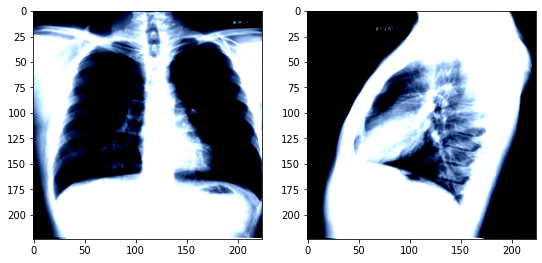

In [106]:
enc_dec_model(2,Algo = 'greedy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size normal . the mediastinal contour within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the heart mildly enlarged .  pulmonary vascularity increased .  there again mild elevation the right hemidiaphragm .  air space disease andor atelectasis noted right lung base .  there also streaky opacity the left base .  the costophrenic are blunted .  endseq


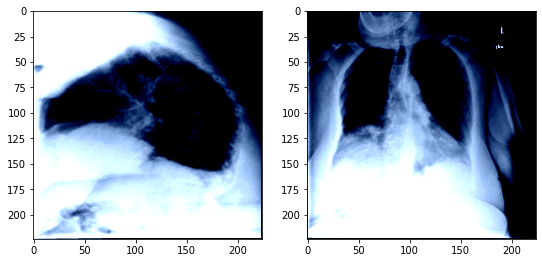

In [107]:
enc_dec_model(98,Algo = 'greedy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size and mediastinal contours are within normal limits . no focal consolidation pleural pleural effusion .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the heart normal size .  the mediastinum unremarkable .  there again biapical scarring .  small stable calcified left lower lobe granuloma .  the lungs are otherwise clear .  endseq


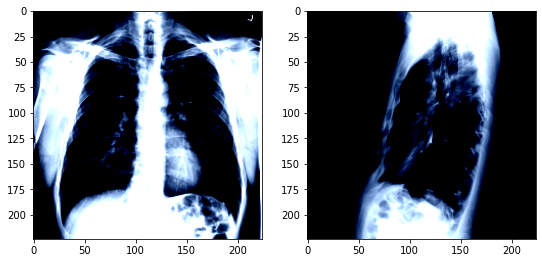

In [108]:
enc_dec_model(48,Algo = 'greedy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size and mediastinal contours are within normal limits . no focal airspace consolidation pleural effusion pneumothora .
Score is : 0.5701761486055884
------------------------------------------------------------------------------------------------------
Actual Report :  startseq no pneumothora .  no large pleural effusions .  heart size normal .  no acute focal space opacities .  endseq


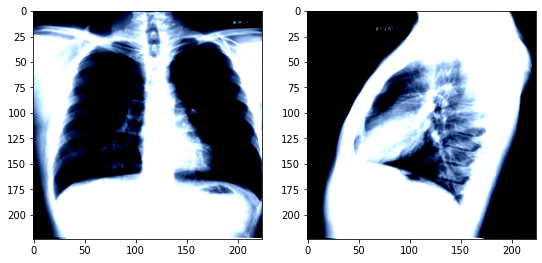

In [109]:
enc_dec_model(2,Algo = 'beam')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart normal size . the mediastinum unremarkable . the lungs are free focal airspace disease . no pleural effusion pneumothora .
Score is : 0.61768415896222
------------------------------------------------------------------------------------------------------
Actual Report :  startseq normal heart size and mediastinal contours .  low lung volumes with no significant airspace consolidation .  no pleural effusion pneumothora .  visualized osseous structures are unremarkable appearance .  endseq


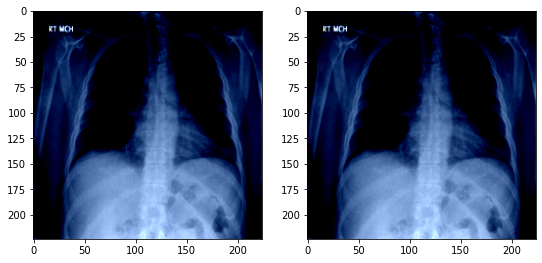

In [110]:
enc_dec_model(5,Algo = 'beam')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the lungs are clear bilaterally . specifically no evidence focal consolidation pneumothora pleural effusion pneumothora cardio mediastinal silhouette unremarkable . visualized osseous structures the thora are without acute abnormality .
Score is : 0.3825261330930516
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the heart size and mediastinal contours appear within normal limits .  there are low lung volumes with left basilar subsegmental atelectasis .  no focal airspace consolidation effusions pneumothora .  no acute bony abnormalities .  endseq


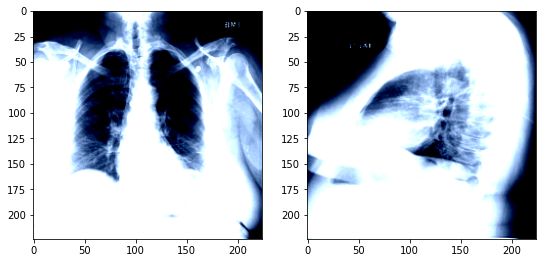

In [113]:
enc_dec_model(37,Algo = 'beam')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart normal size . the mediastinum unremarkable . the lungs are free focal airspace disease . no pleural effusion pneumothora .
Score is : 0.5942948383744806
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the cardiac and mediastinal contours are within normal limits .  there are calcified mediastinal lymph with calcified right lower lobe pulmonary nodule .  the lungs are wellinflated and clear .  there no focal consolidation pneumothora effusion .  there are degenerative changes the first costochondral joints bilaterally .  no acute bony abnormalities are seen .  endseq


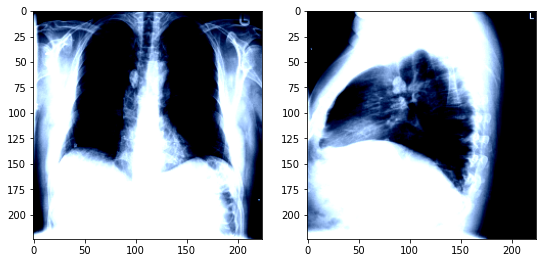

In [114]:
enc_dec_model(89,Algo = 'beam')

# Function 2

In [116]:
def enc_dec_model_pred(input_image_idx,Algo = 'greedy'):

    '''This fun takes index of an image as input and prints predicted result'''

  input1 = Input(shape=(2048), name='Image_input')
  dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

  input2 = Input(shape=(153), name='Text_Input')
  embedding_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=False, 
                weights=[embedding_matrix], name="Embedding_layer")
  emb = embedding_layer(input2)

  LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
  #LSTM1_output = LSTM1(emb)

  LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
  LSTM2_output = LSTM2(LSTM1)

  dropout1 = Dropout(0.5, name='dropout1')(LSTM2_output)

  dec =  tf.keras.layers.Add()([dense1, dropout1])

  fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
  fc1_output = fc1(dec)
  dropout2 = Dropout(0.4, name='dropout2')(fc1_output)
  output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
  output = output_layer(dropout2)

  encoder_decoder = Model(inputs = [input1, input2], outputs = output)
  encoder_decoder.load_weights("/content/encoder_decoder_epoch_5.h5")

  # encoder
  encoder_input = encoder_decoder.input[0]
  encoder_output = encoder_decoder.get_layer('dense_encoder').output
  encoder_model = Model(encoder_input, encoder_output)

  # decoder# 
  text_input = encoder_decoder.input[1]
  enc_output = Input(shape=(256,), name='Enc_Output')
  text_output = encoder_decoder.get_layer('LSTM2').output
  add1 = tf.keras.layers.Add()([text_output, enc_output])
  fc_1 = fc1(add1)
  decoder_output = output_layer(fc_1)

  decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

  def greedysearch(img):
    image = cheXnet_Features[img]
    input_ = 'startseq'
    image_features = encoder_model.predict(image)
    
    result = []
    for i in range(153):
        input_tok = [tokenizer.word_index[w] for w in input_.split()]
        input_padded = pad_sequences([input_tok], 153, padding='post')
        predictions = decoder_model.predict([input_padded, image_features])
        arg = np.argmax(predictions)
        if arg != 7:   # endseq
            result.append(tokenizer.index_word[arg])
            input_ = input_ + ' ' + tokenizer.index_word[arg]
        else:
            break
    rep = ' '.join(e for e in result)
    return rep

  def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X 

  def get_result(idx=0):
  
    plt.figure(figsize=(9,5))

    pre_Report = greedysearch(test_data['Person_id'][idx]) # result after 20 epochs
    print('------------------------------------------------------------------------------------------------------')
    print("Predicted Report : ",pre_Report)

    plt.subplot(121)
    img = load_image(test_data['Image1'][idx])
    plt.imshow(img[0])

    plt.subplot(122)
    img = load_image(test_data['Image2'][idx])
    plt.imshow(img[0]) 

  # beam_width = 2
  def beamsearch(image, beam_width = 2):
    
      start = [tokenizer.word_index['startseq']]

      sequences = [[start, 0]]
    
      img_features = cheXnet_Features[image]
      img_features = encoder_model.predict(img_features)
      finished_seq = []
    
      for i in range(153):
          all_candidates = []
          new_seq = []
          for s in sequences:

              text_input = pad_sequences([s[0]], 153, padding='post')
              predictions = decoder_model.predict([text_input,img_features])
              top_words = np.argsort(predictions[0])[-beam_width:] 
              seq, score = s
            
              for t in top_words:
                  candidates = [seq + [t], score - np.log(predictions[0][t])]
                  all_candidates.append(candidates)
                
          sequences = sorted(all_candidates, key = lambda l: l[1])[:beam_width]
          # checks for 'endseq' in each seq in the beam
          count = 0
          for seq,score in sequences:
              if seq[len(seq)-1] == tokenizer.word_index['endseq']:
                  score = score/len(seq)   # normalized
                  finished_seq.append([seq, score])
                  count+=1
              else:
                  new_seq.append([seq, score])
          beam_width -= count
          sequences = new_seq
        
          # if all the sequences reaches its end before 155 timesteps
          if not sequences:
              break
          else:
              continue
        
      sequences = finished_seq[-1] 
      rep = sequences[0]
      score = sequences[1]
      temp = []
      rep.pop(0)
      for word in rep:
          if word != tokenizer.word_index['endseq']:
              temp.append(tokenizer.index_word[word])
          else:
              break    
      rep = ' '.join(e for e in temp)        
    
      return rep, score

  def get_result_beam(idx,beam_width):
  
    plt.figure(figsize=(9,5))

    pre_Report,Score = beamsearch(test_data['Person_id'][idx],beam_width) # result after 20 epochs
    print('------------------------------------------------------------------------------------------------------')
    print("Predicted Report : ",pre_Report)
    print('Score is :',Score)

    plt.subplot(121)
    img = load_image(test_data['Image1'][idx])
    plt.imshow(img[0])

    plt.subplot(122)
    img = load_image(test_data['Image2'][idx])
    plt.imshow(img[0])

  if Algo == 'greedy':
    get_result(input_image_idx)
  if  Algo == 'beam':
    get_result_beam(input_image_idx,beam_width=5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the lungs are clear bilaterally . specifically no evidence focal consolidation pneumothora pleural effusion pneumothora cardio mediastinal silhouette unremarkable . visualized osseous structures the thora are without acute abnormality .
Score is : 0.38339576142607257


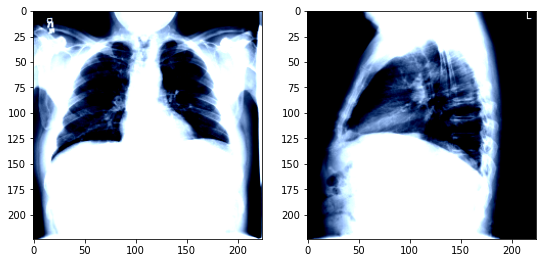

In [118]:
enc_dec_model_pred(89,Algo = 'beam')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size and mediastinal contours are within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora .
Score is : 0.5883563925744966


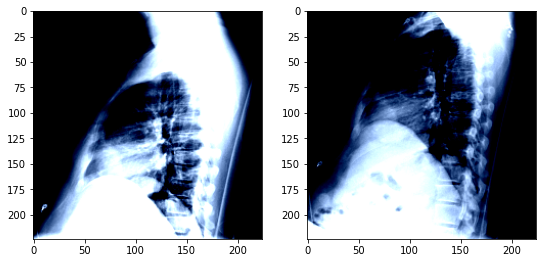

In [119]:
enc_dec_model_pred(12,Algo = 'beam')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size and mediastinal contours are within normal limits . no focal airspace consolidation pneumothora effusion pneumothora .
Score is : 0.6146528686721078


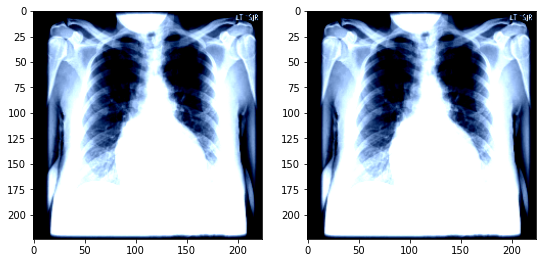

In [120]:
enc_dec_model_pred(21,Algo = 'beam')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the lungs are clear bilaterally . specifically no evidence focal consolidation pneumothora pleural effusion pneumothora cardio mediastinal silhouette unremarkable . visualized osseous structures the thora are without acute abnormality .
Score is : 0.42667727160733193


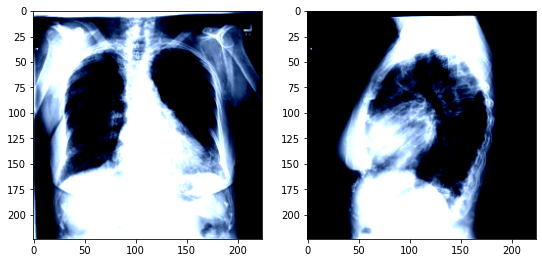

In [122]:
enc_dec_model_pred(118,Algo = 'beam')